## Лабораторная работа №1
`Выполнил: Жигалов Григорий`
___
Предлагается задача бинарной классификации. Параметры выборок: 15000 объектов для обучения, 4020 объектов для теста, 10 числовых признаков.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ShuffleSplit, cross_val_score, GridSearchCV

sns.reset_orig()
%matplotlib inline

### Чтение данных

In [2]:
train = pd.read_csv('data/train.txt', sep=' ', header=None)
labels = pd.read_csv('data/train_labels.txt', header=None, names=['label'])

### Матрица корреляций

Для некоторой визуализации данных построим матрицу корреляции признаков между собой и со столбцом label. 

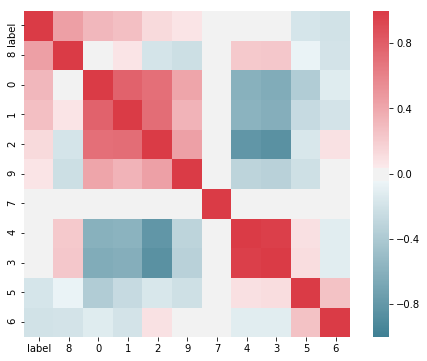

In [3]:
f, ax = plt.subplots(figsize=(8, 6))
corr = train.join(labels).corr().sort_values('label', axis=1, ascending=False).sort_values('label', axis=0, ascending=False)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()

### Разделение на train/validation

Случайно разделяем данные на train/validation так, чтобы 30% выборки осталось на validation

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train, labels, test_size=0.3)

____
## Обучение моделей

In [5]:
def score_model(estimator, X, y):
    cv = ShuffleSplit(n_splits=10)
    return cross_val_score(estimator, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=-1).mean()

### kNN

In [15]:
knn = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_jobs=-1)
)

In [16]:
knn = knn.fit(X_train, y_train['label'].tolist())

In [17]:
score_model(knn, X_val, y_val['label'].tolist())

0.8233333333333333

kNN со стандартными параметрами даёт ~82% точности. Попробуем улучшить результат поискав оптимальное количество ближайших соседей.

In [18]:
knn_res = {'n': [], 'error': []}
for n in range(2, 15):
    knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=n, n_jobs=-1)).fit(X_train, y_train['label'].tolist())
    knn_res['n'].append(n)
    knn_res['error'].append(1 - score_model(knn, X_val, y_val['label'].tolist()))

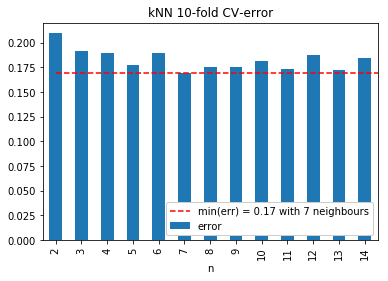

In [19]:
min_error, min_n = min(zip(knn_res['n'], knn_res['error']), key=lambda x: x[1])
pd.DataFrame.from_dict(knn_res).plot.bar(x='n')
plt.plot([0, 30], [min(knn_res['error'])]*2, '--r', 
         label='min(err) = {:.2f} with {} neighbours'.format(min_n, min_error))
plt.legend(loc='lower right', framealpha=1)
plt.title('kNN 10-fold CV-error')
plt.show()

В итоге kNN показал лучший результат в 83% точности при 7 ближайших соседях.

### SVM

In [26]:
svm = make_pipeline(MinMaxScaler(), SVC())

In [27]:
svm = svm.fit(X_train, y_train['label'].tolist())

In [28]:
score_model(svm, X_val, y_val['label'].tolist())

0.8004444444444443

Использование svm со стандартными параметрами показывает реузультат чуть хуже kNN. Попробуем оптимизировать параметр регуляризации C и коэффициент gamma.

In [35]:
param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svc__gamma' : [0.01, 0.1, 1]}
svm_gs = GridSearchCV(make_pipeline(MinMaxScaler(), SVC(kernel='rbf')),
                      param_grid, cv=ShuffleSplit(), n_jobs=-1)
svmg_gs = svm_gs.fit(train, labels['label'].tolist()) # Делаем GS по всему датасету, т.к. используется CV

In [36]:
svm_gs.best_params_

{'svc__C': 1000, 'svc__gamma': 1}

In [37]:
svm_gs.best_score_

0.8746

При увеличении C наблюдаем заметное улучшение точности модели. Для C=1000 и gamma=1 модель SVM показывает лучший результат в 87% точности.

### Random forest

In [72]:
rf = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_jobs=-1))

In [73]:
rf = rf.fit(X_train, y_train['label'].tolist())

In [74]:
score_model(rf, X_val, y_val['label'].tolist())

0.8608888888888888

Random Forest со стандартными параметрами показывает результат уступающий SVM. Организуем поиск оптимальных параметров:

In [85]:
distr = {
    'minmaxscaler': [None, MinMaxScaler()],
    'randomforestclassifier__n_estimators': scipy.stats.randint(2, 100),
    'randomforestclassifier__max_depth': scipy.stats.randint(2, 15),
    'randomforestclassifier__max_features': ["auto", "sqrt", "log2", None]
}
rf_gs = RandomizedSearchCV(make_pipeline(MinMaxScaler(), RandomForestClassifier(n_jobs=-1)), n_iter=100, 
                           param_distributions=distr, cv=ShuffleSplit(n_splits=10), n_jobs=-1)

In [86]:
rf_gs = rf_gs.fit(train, labels['label'].tolist())

In [88]:
rf_gs.best_params_

{'minmaxscaler': None,
 'randomforestclassifier__max_depth': 14,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__n_estimators': 72}

In [89]:
rf_gs.best_score_

0.8775333333333334

Оптимизировав количество деревьев, максимальную высоту и максимальное количество используемых фич мы смогли улучшить результат и даже превзойти SVM.

### Gradient boosting

In [90]:
gbc = make_pipeline(MinMaxScaler(), GradientBoostingClassifier())

In [64]:
gbc = gbc.fit(X_train, y_train['label'].tolist())

In [65]:
score_model(gbc, X_val, y_val['label'].tolist())

0.860888888888889

In [109]:
distr = {
    'minmaxscaler': [None, MinMaxScaler()],
    'gradientboostingclassifier__loss': ['deviance', 'exponential'],
    'gradientboostingclassifier__n_estimators': scipy.stats.randint(2, 100),
    'gradientboostingclassifier__max_depth': scipy.stats.randint(2, 15),
    'gradientboostingclassifier__max_features': scipy.stats.randint(2, 10)
}
gbc_gs = RandomizedSearchCV(make_pipeline(MinMaxScaler(), GradientBoostingClassifier()), n_iter=100, 
                            param_distributions=distr, cv=ShuffleSplit(n_splits=10), n_jobs=-1)

In [110]:
gbc_gs = gbc_gs.fit(train, labels['label'].tolist())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.9min finished


In [111]:
gbc_gs.best_params_

{'gradientboostingclassifier__loss': 'exponential',
 'gradientboostingclassifier__max_depth': 12,
 'gradientboostingclassifier__max_features': 4,
 'gradientboostingclassifier__n_estimators': 89,
 'minmaxscaler': None}

In [112]:
gbc_gs.best_score_

0.8852666666666666

## Выбор итогового классификатора

In [115]:
results = {
    'kNN': min(knn_res['error']),
    'SVM': 1 - svm_gs.best_score_,
    'RF': 1 - rf_gs.best_score_,
    'GBT': 1 - gbc_gs.best_score_
}

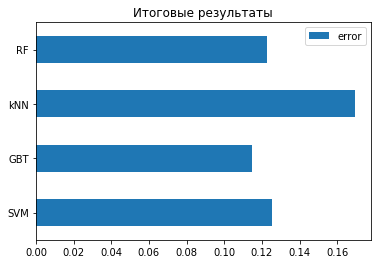

In [116]:
pd.DataFrame.from_dict(results, orient='index').rename(columns={0:'error'}).plot(kind='barh')
plt.title('Итоговые результаты')
plt.show()

Как можно увидеть на графике выше, метод градиентного бустинга для данного датасета показал результат чуть лучше метода Random Forest. Он и будет использоваться для предсказания на тестовой выборке.

## Тестовая выборка

In [122]:
test = pd.read_csv('data/test.txt', sep=' ', header=None)

In [123]:
test['label'] = gbc_gs.best_estimator_.predict(test)

In [124]:
test[['label']].to_csv('test_labels.txt', index=False)